# 2.- Bike Sharing: Predicción de Demanda Horaria

**a)** Cargue los datos de entrenamiento y pruebas como dataframes de _pandas_. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distintos y, si corresponde, un gráfico (e.g. un histograma) que resuma su comportamiento. Su primera operación de pre-procesamiento de datos será obtener la hora del día desde el campo fecha (que en este momento es de tipo string), creando una nueva columna denominada hour y de tipo int. Para hacer esta operación se concatenarán los dataframes de entrenamiento y pruebas y luego se volverán a separar manteniendo la separación original.

In [3]:
import pandas as pd
import numpy as np

dftrain = pd.read_csv('data/bike_sharing_train.csv')
dfval = pd.read_csv('data/bike_sharing_val.csv')
dftest = pd.read_csv('data/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])

print('\nSummary - dataframe completo:\n')
print(df.describe())
df.head()


Summary - dataframe completo:

         Unnamed: 0        season       holiday    workingday       weather  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean    5442.500000      2.506614      0.028569      0.680875      1.418427   
std     3142.661849      1.116174      0.166599      0.466159      0.633839   
min        0.000000      1.000000      0.000000      0.000000      1.000000   
25%     2721.250000      2.000000      0.000000      0.000000      1.000000   
50%     5442.500000      3.000000      0.000000      1.000000      1.000000   
75%     8163.750000      4.000000      0.000000      1.000000      2.000000   
max    10885.000000      4.000000      1.000000      1.000000      4.000000   

              temp         atemp      humidity     windspeed        casual  \
count  10886.00000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      20.23086     23.655084     61.886460     12.799395     36.021955   
std        7.79159    

,Unnamed: 0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
1,4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
2,5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
3,6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
4,7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3


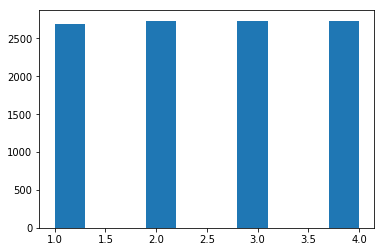

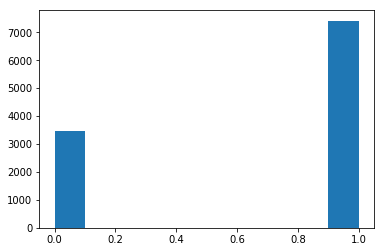

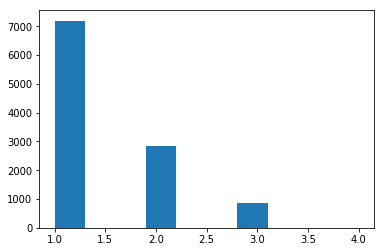

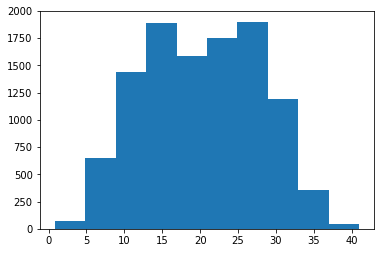

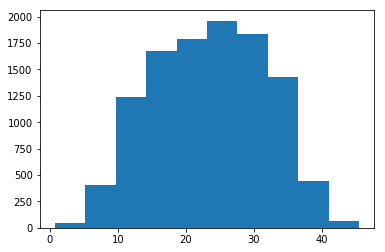

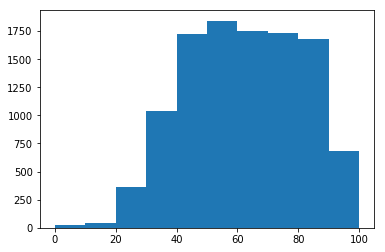

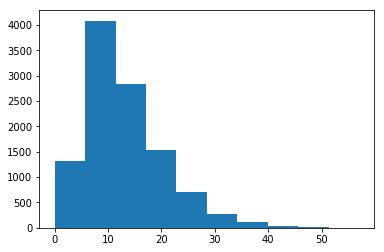

In [4]:
import matplotlib.pyplot as plt

for column in ['season','workingday','weather','temp', 'atemp', 'humidity', 'windspeed']:
    plt.hist(df[column])
    plt.show()

In [5]:
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]
Ydf=df.loc[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

**b)** Entrene un árbol de regresión para resolver el problema usando parámetros por defecto. Con este fin, construya una matriz $X_{train}$ de forma $n_{train} \times d_1$ que contenga los datos de entrenamiento en sus filas, seleccionando las columnas que desee/pueda utilizar para el entrenamiento. Implemente además, la función de evaluación que hemos definido anteriormente para este problema. Evalúe el árbol de regresión ajustado a los datos de entrenamiento sobre el conjunto de entrenamiento y pruebas. Construya un gráfico que compare las predicciones con los valores reales. En este punto usted debiese tener un modelo con puntaje del orden de 0.59, lo que lo dejará más o menos en la posición 2140 de la competencia.

SCORE TEST=0.703388
KAGG EVAL TRAIN =0.028516
KAGG EVAL TEST =0.574239


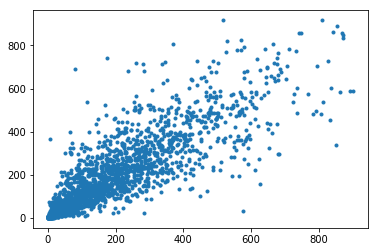

In [6]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

def eval_bikemodel(y_predict,y_true,**kwargs):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

model = DecisionTreeRegressor(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)

print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

**c)** Mejore el árbol de regresión definido en el punto anterior haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, como estos modelos tienden a sobre-ajustar, podría intentar limitar la profundidad del árbol (¿Por qué esto debiese ayudar?). Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. Con estas modificaciones debiese poder mejorar su ranking en unas 300 posiciones.

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def train_tree(X,Y,crit=["mse","mae"],max_depth=30,min_depth=5):
    scores = []
    count,current = len(crit)*(max_depth-min_depth+1),1
    for d in range(min_depth,max_depth+1):
        for c in crit:
            model = DecisionTreeRegressor(random_state=0,max_depth=d,criterion=c)
            score = 0#cross_val_score(model, X,Y).mean()
            score_bike = cross_val_score(model, X,Y, scoring=make_scorer(eval_bikemodel)).mean()
            scores.append([model, score, score_bike, c, d])
            # print("\t Score:%f \t BikeScore:%f \t Max Depth: %d \t Criterion: %s"%(score,score_bike,d,c))
            print ("%d/%d"%(current,count), end="\r")
            current+=1
    return scores

scores = train_tree(np.concatenate([X_train,X_val]),np.concatenate([Y_train,Y_val]),max_depth=20,min_depth=5)

In [10]:
def top_scores(scores):
    sorted_scores = sorted(scores, key=(lambda x: -x[2]), reverse=False)
    print("Top 10 models:")
    for s in sorted_scores[-10:]:
        print("  Score:%f \t BikeScore:%f \t Max Depth: %d \t Criterion: %s"%(s[1],s[2],s[4],s[3]))
    return sorted_scores[-1]

t=top_scores(scores)

Top 10 models:
  Score:0.000000 	 BikeScore:0.592093 	 Max Depth: 13 	 Criterion: mae
  Score:0.000000 	 BikeScore:0.588915 	 Max Depth: 12 	 Criterion: mse
  Score:0.000000 	 BikeScore:0.583421 	 Max Depth: 9 	 Criterion: mae
  Score:0.000000 	 BikeScore:0.582569 	 Max Depth: 8 	 Criterion: mae
  Score:0.000000 	 BikeScore:0.580230 	 Max Depth: 11 	 Criterion: mse
  Score:0.000000 	 BikeScore:0.579067 	 Max Depth: 11 	 Criterion: mae
  Score:0.000000 	 BikeScore:0.577337 	 Max Depth: 10 	 Criterion: mae
  Score:0.000000 	 BikeScore:0.573863 	 Max Depth: 8 	 Criterion: mse
  Score:0.000000 	 BikeScore:0.570939 	 Max Depth: 10 	 Criterion: mse
  Score:0.000000 	 BikeScore:0.566530 	 Max Depth: 9 	 Criterion: mse


In [12]:
t[0].fit(np.concatenate([X_train,X_val]),np.concatenate([Y_train,Y_val]))
print("Top BikeScore Test: %f"%eval_bikemodel(t[0].predict(X_test),Y_test))

Top BikeScore Test: 0.490544


Se utilizó validación cruzada con la finalidad de no guiarse por una sola evaluación, la que podría ser "buena" por cosa de suerte.

Además se varió la profundidad del árbol, teniendo en cuanta que un número muy alto causará overfitting del modelo. Junto s esto, también se varió el criterio de decisión utilizado. 

Como se puede ver en esta lista, las mejores configuraciones fueron mse ó friedman_mse con una profundidad de 9.

**d)**  Mejore el árbol de regresión definido en el punto anterior haciendo modificaciones sobre la representación utilizada para aprender desde los datos. Por ejemplo, los histogramas que construyó en el punto (a) así como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta. Podría intentar también normalizando los datos o normalizando la respuesta. Otra opción es intentar rescatar algo más acerca de la fecha (anteriormente sólo se extrajo la hora), como por ejemplo el año o el día de la semana ('lunes','martes', etc) que corresponde. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo. Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raíz cuadrada), debe invertir esta transformación antes de evaluar el desempeño con *eval_bikemodel* (por ejemplo, elevar al cuadrado si tomó raíz cuadrada). Con modificaciones de este tipo, podría mejorar su ranking en unas 1000 posiciones, entrando ya al top-1000 con un score del orden de $0.45$.

In [41]:
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek #0:lunes,6:domingo
df['cday'] = pd.to_numeric(df['cday'])

df['cyear'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%Y'))
df['cyear'] = pd.to_numeric(df['cyear'])

df['cmonth'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%m'))
df['cmonth'] = pd.to_numeric(df['cmonth'])

df['ghour'] = df['hour'].apply(lambda x: int(x/3))
df['gatemp'] = df['atemp'].apply(lambda x: int(x/3))

df['holiday'] = pd.to_numeric(df['holiday'])
df['workingday'] = pd.to_numeric(df['workingday'])
df['tday'] = df['holiday'] + 2*df['workingday']

df['humidity'] = pd.to_numeric(df['humidity'])

Xdf=df.loc[:,['season','weather','humidity','cday','hour','cyear','tday','gatemp']]
Xdf.head()

,season,weather,humidity,cday,hour,cyear,tday,gatemp
0,1,1,75,5,3,2011,0,4
1,1,1,75,5,4,2011,0,4
2,1,2,75,5,5,2011,0,4
3,1,1,80,5,6,2011,0,4
4,1,1,86,5,7,2011,0,4


In [42]:
X_train2 = Xdf[0:nval].values
Y_train2 = Ydf[0:nval].values

X_test2 = Xdf[nval:].values
Y_test2 = Ydf[nval:].values

scores2 = train_tree(X_train2,Y_train2,crit=["mse","mae"],max_depth=15,min_depth=5)
t=top_scores(scores2)

Top 10 models:
  Score:0.000000 	 BikeScore:0.468551 	 Max Depth: 12 	 Criterion: mae
  Score:0.000000 	 BikeScore:0.467679 	 Max Depth: 10 	 Criterion: mae
  Score:0.000000 	 BikeScore:0.464680 	 Max Depth: 11 	 Criterion: mae
  Score:0.000000 	 BikeScore:0.464342 	 Max Depth: 15 	 Criterion: mse
  Score:0.000000 	 BikeScore:0.459172 	 Max Depth: 13 	 Criterion: mse
  Score:0.000000 	 BikeScore:0.459068 	 Max Depth: 14 	 Criterion: mse
  Score:0.000000 	 BikeScore:0.455209 	 Max Depth: 9 	 Criterion: mse
  Score:0.000000 	 BikeScore:0.451104 	 Max Depth: 12 	 Criterion: mse
  Score:0.000000 	 BikeScore:0.443767 	 Max Depth: 10 	 Criterion: mse
  Score:0.000000 	 BikeScore:0.441475 	 Max Depth: 11 	 Criterion: mse


In [43]:
t[0].fit(X_train2,Y_train2)
print("Top BikeScore Test: %f"%eval_bikemodel(t[0].predict(X_test2),Y_test2))

Top BikeScore Test: 0.412036


**e)** Entrene una SVM no lineal para resolver el problema midiendo el efecto de las distintas representaciones que haya descubierto hasta este punto. Un detalle importante es que antes de entrenar la SVM sería aconsejable hacer dos tipos de pre-procesamiento adicional de los datos: (i) codificar las variables categóricas en un modo apropiado - por ejemplo como vector binario con un 1 en la posición del valor adoptado-, (ii) escalar los atributos de modo que queden centrados y con rangos comparables. Usando parámetros por defecto para la SVM debiese obtener un score del orden de $0.344$, quedando definitivamente en el top-10 de la competencia.

In [45]:
df['day_weekend'] = df['tday'].apply(lambda x: x==0)
df['day_holiday'] = df['tday'].apply(lambda x: x==1)
df['day_work'] = df['tday'].apply(lambda x: x==2)

df['season_spr'] = df['season'].apply(lambda x: x==1)
df['season_sum'] = df['season'].apply(lambda x: x==2)
df['season_fal'] = df['season'].apply(lambda x: x==3)
df['season_win'] = df['season'].apply(lambda x: x==4)

df['weather_clear'] = df['weather'].apply(lambda x: x==1)
df['weather_mist'] = df['weather'].apply(lambda x: x==2)
df['weather_snow'] = df['weather'].apply(lambda x: x==3)
df['weather_rain'] = df['weather'].apply(lambda x: x==4)


Xdf=df.loc[:,['humidity','windspeed','hour',
              'cday','cyear','gatemp',
              'day_weekend', 'day_holiday', 'day_work', 
              'season_spr', 'season_sum', 'season_fal', 'season_win', 
              'weather_clear', 'weather_mist', 'weather_snow', 'weather_rain']]

Ydf=df.loc[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

In [46]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

from sklearn.svm import SVR
model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = np.absolute(model.predict(X_test))

print("Top BikeScore Test: %f"%eval_bikemodel(Y_pred_test,Y_test))

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Top BikeScore Test: 1.081873


<p  style="text-align: justify;"> 
    **(f)** Mejore la SVM definida en el punto anterior haciendo modificaciones a los hiper-parámetros de la máquina ($C$, $\epsilon$ o la misma función de kernel). Naturalmente, está absolutamente prohibido tomar este tipo de decisiones de diseño mirando el resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento.


</p>

In [ ]:
model = SVR(C=1,epsilon=0.01)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)

<p  style="text-align: justify;"> 
    **(g)**  Evaúe el efecto de utilizar el dataset de validación para entrenamiento y seleccionar los parámetros estructurales del árbol de clasificación y la SVM usando validación cruzada. El código de ejemplo para esto ha sido proporcionado en las tareas 1 y 2, pero se adjunta de nuevo a continuación
</p>

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
mse_cv = 0
for train, val in kf.split(Xm):
    model = #define your model
    model.fit(Xm[train], ym[train])
    yhat_val = model.predict(Xm[val])
    ytrue_val = ym[val]
    score_fold = eval_bikemodel(yhat_val,ytrue_val)
    mse_cv += score_fold
    mse_cv = mse_cv / 10

<p  style="text-align: justify;"> 
asdfs
</p>


<p  style="text-align: justify;"> 
    **(h)**  Evalúe el efecto de utilizar un ensamblado de 2 máquinas de aprendizaje para predecir la demanda total de bicicletas. Un modelo se especializará en la predicción de la demanda de bicicletas de parte de usuarios registrados y otra en la predicción de la demanda de usuarios casuales. Hay razones claras para pensar que los patrones son distintos.
</p>

In [ ]:
Ydf=df.ix[:,'count'] #demanda total
Ydf=df.ix[:,'registered'] #demanda registrada
Ydf=df.ix[:,'casual'] #demanda casual

<p  style="text-align: justify;"> 
    **(i)**  Evalúe el efecto de utilizar un algoritmo genérico para ensamblar máquinas de aprendizaje para predecir la demanda total de bicicletas. Puede experimentar con una sola técnica (e.g. Random Forest), discuta la evolución a medida que aumenta el número de máquinas.
</p>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10,max_depth=max_depth,random_state=0)